<a href="https://colab.research.google.com/github/dumbcoder7/Restaurant-Recommender/blob/main/Restaurant_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Restaurant Recommender Based On PySpark



#### Setting up the environment

In Google Colab, we fetch the spark modules, configure and install them. 
We also import libraries like matplotlib that can help us visualize the data.
We create an object of the SparkContext and name it 'sc'. The first cell may take longer to run.


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import matplotlib.pyplot as plt
import os
import findspark


In [5]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
findspark.init()

from pyspark import SparkContext
sc = SparkContext("local")


I have provided both 'entree_data.tar.gz' zipped folder as well as the extracted files and folder. You can use either one to run the project. Only run the below cell if you are using the zipped folder.


In [6]:
!tar xf entree_data.tar.gz

In [7]:
!ls

entree		    sample_data		       spark-2.4.7-bin-hadoop2.7.tgz
entree_data.tar.gz  spark-2.4.7-bin-hadoop2.7


#### Processing the session files.

Here, we will first use the session file to generate popularity score of each restaurant.


In [8]:
obj = {'Atlanta': [], 'Boston': [], 'Chicago':[], 'Los Angeles':[], 'New Orleans':[], 'New York':[], 'San Francisco':[], 'Washington D.C.':[]}

def trail(x):
  if len(x)==1:
    return "000000"+x
  elif len(x)==2:
    return "00000"+x
  elif len(x)==3:
    return "0000"+x

def locmap(x):
    if(x[-1]=='A'):
      return ('Atlanta',trail(x[:-1]))
    elif(x[-1]=='B'):
      return ('Boston',trail(x[:-1]))
    elif(x[-1]=='C'):
      return ('Chicago',trail(x[:-1]))
    elif(x[-1]=='E'):
      return ('New Orleans',trail(x[:-1]))
    elif(x[-1]=='F'):
      return ('New York',trail(x[:-1]))
    elif(x[-1]=='G'):
      return ('San Francisco',trail(x[:-1]))
    elif(x[-1]=='D'):
      return ('Los Angeles',trail(x[:-1]))
    elif(x[-1]=='H'):
      return ('Washington D.C.',trail(x[:-1]))

def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a

sess = sc.textFile("entree/session/session.19*").map(lambda s: s.split("\t")).map(lambda s: s[2])
print("Number of rows before filtering: ", sess.count())
sess = sess.filter(lambda x: x[0]!='0')


print("Number of rows after filtering: ", sess.count())
sess = sc.parallelize(sess.map(lambda x: locmap(x)).collect())
sess=sess.combineByKey(to_list, append, extend).collect()

print("Example of data being stored in the 'sess' object")
for i in sess:
  print(i[0], i[1][:5], "\t \t Total restaurants: ",len(i[1]))

Number of rows before filtering:  50672
Number of rows after filtering:  5995
Example of data being stored in the 'sess' object
Chicago ['0000223', '0000553', '0000260', '0000410', '0000162'] 	 	 Total restaurants:  4990
Washington D.C. ['0000167', '0000375', '0000058', '0000161', '0000214'] 	 	 Total restaurants:  118
Los Angeles ['0000402', '0000402', '0000402', '0000180', '0000180'] 	 	 Total restaurants:  180
New York ['0000130', '0000130', '0000130', '0000135', '0000130'] 	 	 Total restaurants:  278
San Francisco ['0000208', '0000362', '0000198', '0000204', '0000250'] 	 	 Total restaurants:  129
Atlanta ['0000147', '0000194', '0000184', '0000072', '0000194'] 	 	 Total restaurants:  71
Boston ['0000381', '0000140', '0000071', '0000215', '0000023'] 	 	 Total restaurants:  129
New Orleans ['0000274', '0000024', '0000035', '0000100', '0000024'] 	 	 Total restaurants:  100


As can be seen above, after filtering almost 90% of the data is lost. We can conclude that this process is optional or is rather harming the correctness of the program. But it includes some important PySpark concepts and hence, I would rather not modify it.

#### Onto the Data folder

In the following function, we shall only be considering 4 parameters as important: 



1.   The ID of the restaurant
2.   The list of features
3.   The city in which the restaurant is present
4.   The name of the restaurant
5.   The popularity score




In [9]:
def stream(s, city):
  for i in sess:
    if(i[0]==city):
      popularity = i[1].count(s[0])
  return (s[1], s[2].split(), city,  s[0],popularity)

Here, we are creating RDDs and transforming them based on our needs. We are also maintaining counts of each city in the `resto` list.


In [11]:
resto=[]
atlanta = sc.textFile('entree/data/atlanta.txt')
atlanta = atlanta.map(lambda s: s.split('\t')).map(lambda s:stream(s, 'Atlanta'))
atcount = atlanta.count()
resto.append(atcount)
boston = sc.textFile('entree/data/boston.txt')
boston = boston.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'Boston'))
bocount = boston.count()
resto.append(bocount)
chicago = sc.textFile('entree/data/chicago.txt')
chicago = chicago.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'Chicago'))
chcount = chicago.count()
resto.append(chcount)
los_angeles = sc.textFile('entree/data/los_angeles.txt')
los_angeles = los_angeles.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'Los Angeles'))
lacount = los_angeles.count()
resto.append(lacount)
new_orleans = sc.textFile('entree/data/new_orleans.txt')
new_orleans = new_orleans.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'New Orleans'))
nocount = new_orleans.count()
resto.append(nocount)
new_york = sc.textFile('entree/data/new_york.txt')
new_york = new_york.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'New York'))
nycount = new_york.count()
resto.append(nycount)
san_francisco = sc.textFile('entree/data/san_francisco.txt')
san_francisco = san_francisco.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'San Francisco'))
sfcount = san_francisco.count()
resto.append(sfcount)
washington_dc = sc.textFile('entree/data/washington_dc.txt')
washington_dc = washington_dc.map(lambda s: s.split('\t')).map(lambda s: stream(s, 'Washington D.C.'))
wacount = washington_dc.count()
resto.append(wacount)





Here we have a visualization of the data distribution. As we can see, the data is not necessarily distributed uniformly but the numbers are fairly comparable.

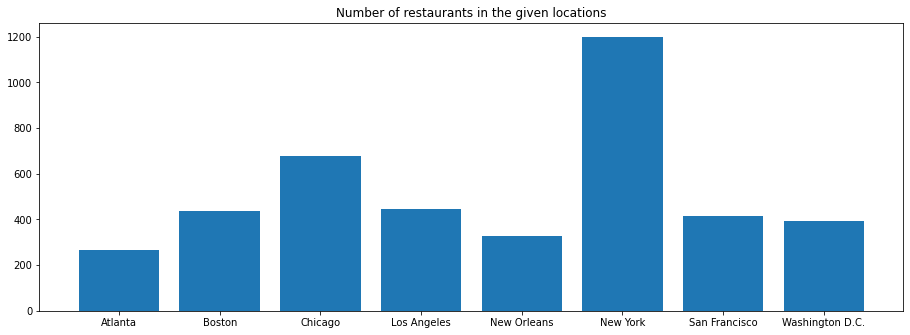

Total Count: 4160


In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
cities = ['Atlanta', 'Boston', 'Chicago', 'Los Angeles', 'New Orleans', 'New York', 'San Francisco', 'Washington D.C.']
ax.bar(cities,resto)
ax.set_title('Number of restaurants in the given locations')

plt.show()

print("Total Count: " + str(atcount+bocount+chcount+lacount+nocount+nycount+sfcount+wacount))


We combine the data by taking a union of all RDDs. 
We filter the restaurants that have 'CLOSED' in their names. This enables us to only provide results of the available restaurants.

In [14]:
final = sc.union([atlanta,boston, chicago, los_angeles, new_orleans, new_york, san_francisco, washington_dc]).filter(lambda s: "(" not in s[0]).sortBy(lambda x: x[0].strip())

final.take(5)


[('101', ['125', '075', '205', '053', '166'], 'New York', '0001096', 0),
 ('101 Seafood',
  ['125', '212', '075', '205', '053', '166'],
  'New York',
  '0000163',
  1),
 ('103 NYC', ['184', '075', '204', '052', '166'], 'New York', '0000542', 0),
 ('103 WEST',
  ['080',
   '253',
   '099',
   '200',
   '245',
   '196',
   '191',
   '192',
   '146',
   '024',
   '045',
   '076',
   '206',
   '054',
   '167'],
  'Atlanta',
  '0000230',
  1),
 ('107 West', ['075', '204', '052', '165'], 'New York', '0000010', 0)]

A list of all features being considered by the data. There is room for improvement here.

In [15]:
features = sc.textFile('entree/data/features.txt').map(lambda x: x.split("\t"))
features.take(5)
# features.collect()

[['000', 'A'],
 ['001', 'Authentic'],
 ['002', 'Afghanistan'],
 ['003', 'African'],
 ['004', 'After Hours Dining']]

In [16]:
print("Input list of features wanted")
lis = input().split()
print("\n1. Atlanta\n2. Boston\n3. Chicago\n4. Los Angeles\n5. New Orleans\n6. New York\n7. San Francisco\n8. Washington D.C.\n")
location = int(input("Enter a number for location: ")) - 1

def score(x,lis):
  return   len( [value for value in lis if value in x[1]] )
  


temp = final.map(lambda x: (x[0],  score(x,lis), x[2], x[4])).filter(lambda x: x[1] !=0 and x[2]==cities[location]).sortBy(lambda x: (x[1], x[3]),ascending= False )#.sortBy(lambda x:x[-1], ascending = False)
print("Hotels with at least one feature matching: " + str( temp.count()))
temp.take(10)


Input list of features wanted
164 053 253

1. Atlanta
2. Boston
3. Chicago
4. Los Angeles
5. New Orleans
6. New York
7. San Francisco
8. Washington D.C.

Enter a number for location: 1
Hotels with at least one feature matching: 224


[("Houston's", 3, 'Atlanta', 5),
 ("Babette's Cafe", 3, 'Atlanta', 2),
 ('Chile Tree', 3, 'Atlanta', 1),
 ('Haveli', 3, 'Atlanta', 1),
 ('Longhorn Steaks', 3, 'Atlanta', 1),
 ('Outback Steaks', 3, 'Atlanta', 1),
 ('SURIN OF THAILAND', 3, 'Atlanta', 1),
 ("Altobeli's Fine Italian Cuisine", 3, 'Atlanta', 0),
 ('August Moon', 3, 'Atlanta', 0),
 ('Azio', 3, 'Atlanta', 0)]

The output displays the names of the restaurants, the number of matching features, their locations and their popularity score.